# Libraries

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV

# Historical Data for Modeling (Exploring)

In [3]:
modeling_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1976-2020-president.csv')
modeling_df

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party_detailed,writein,candidatevotes,totalvotes,version,notes,party_simplified
0,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"CARTER, JIMMY",DEMOCRAT,False,659170,1182850,20210113,NaN,DEMOCRAT
1,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"FORD, GERALD",REPUBLICAN,False,504070,1182850,20210113,NaN,REPUBLICAN
2,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"MADDOX, LESTER",AMERICAN INDEPENDENT PARTY,False,9198,1182850,20210113,NaN,OTHER
3,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"BUBAR, BENJAMIN """"BEN""""",PROHIBITION,False,6669,1182850,20210113,NaN,OTHER
4,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"HALL, GUS",COMMUNIST PARTY USE,False,1954,1182850,20210113,NaN,OTHER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4282,2020,WYOMING,WY,56,83,68,US PRESIDENT,"JORGENSEN, JO",LIBERTARIAN,False,5768,278503,20210113,NaN,LIBERTARIAN
4283,2020,WYOMING,WY,56,83,68,US PRESIDENT,"PIERCE, BROCK",INDEPENDENT,False,2208,278503,20210113,NaN,OTHER
4284,2020,WYOMING,WY,56,83,68,US PRESIDENT,NaN,NaN,True,1739,278503,20210113,NaN,OTHER
4285,2020,WYOMING,WY,56,83,68,US PRESIDENT,OVERVOTES,NaN,False,279,278503,20210113,NaN,OTHER


Group by Presidential Winner per State by Year

In [4]:
# Group by year and state, and find the candidate with the maximum votes in each group
winners = modeling_df.loc[modeling_df.groupby(['year', 'state'])['candidatevotes'].idxmax()]

# Create the table with desired columns
winner_table = winners[['year', 'state', 'candidate', 'party_detailed']]

# Display the table
print(winner_table)

      year          state            candidate party_detailed
0     1976        ALABAMA        CARTER, JIMMY       DEMOCRAT
7     1976         ALASKA         FORD, GERALD     REPUBLICAN
11    1976        ARIZONA         FORD, GERALD     REPUBLICAN
19    1976       ARKANSAS        CARTER, JIMMY       DEMOCRAT
23    1976     CALIFORNIA         FORD, GERALD     REPUBLICAN
...    ...            ...                  ...            ...
4252  2020       VIRGINIA  BIDEN, JOSEPH R. JR       DEMOCRAT
4256  2020     WASHINGTON  BIDEN, JOSEPH R. JR       DEMOCRAT
4264  2020  WEST VIRGINIA     TRUMP, DONALD J.     REPUBLICAN
4267  2020      WISCONSIN  BIDEN, JOSEPH R. JR       DEMOCRAT
4281  2020        WYOMING     TRUMP, DONALD J.     REPUBLICAN

[612 rows x 4 columns]


# Preprocessing

Adding a Column for State Number (Assigned by Order of Admission into the Union) - Preprocessing the state column

In [5]:
modeling_df = modeling_df.copy()

In [6]:
print(modeling_df['state_po'].unique())

['AL' 'AK' 'AZ' 'AR' 'CA' 'CO' 'CT' 'DE' 'DC' 'FL' 'GA' 'HI' 'ID' 'IL'
 'IN' 'IA' 'KS' 'KY' 'LA' 'ME' 'MD' 'MA' 'MI' 'MN' 'MS' 'MO' 'MT' 'NE'
 'NV' 'NH' 'NJ' 'NM' 'NY' 'NC' 'ND' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC' 'SD'
 'TN' 'TX' 'UT' 'VT' 'VA' 'WA' 'WV' 'WI' 'WY']


In [7]:
# Mapping state abbreviations based on order of admission into the Union
state_admission_order = {
    'DE': 1, 'PA': 2, 'NJ': 3, 'GA': 4, 'CT': 5,
    'MA': 6, 'MD': 7, 'SC': 8, 'NH': 9, 'VA': 10,
    'NY': 11, 'NC': 12, 'RI': 13, 'VT': 14, 'KY': 15,
    'TN': 16, 'OH': 17, 'LA': 18, 'IN': 19, 'MS': 20,
    'IL': 21, 'AL': 22, 'ME': 23, 'MO': 24, 'AR': 25,
    'MI': 26, 'FL': 27, 'TX': 28, 'IA': 29, 'WI': 30,
    'CA': 31, 'MN': 32, 'OR': 33, 'KS': 34, 'WV': 35,
    'NV': 36, 'NE': 37, 'CO': 38, 'ND': 39, 'SD': 40,
    'MT': 41, 'WA': 42, 'ID': 43, 'WY': 44, 'UT': 45,
    'OK': 46, 'NM': 47, 'AZ': 48, 'AK': 49, 'HI': 50
}

In [8]:
# Map state abbreviations to their order of admission
modeling_df['state_num'] = modeling_df['state_po'].map(state_admission_order)

# Check for any missing values in the new column
missing_states = modeling_df[modeling_df['state_num'].isna()]['state_po'].unique()
print(f'Missing state abbreviations: {missing_states}')

Missing state abbreviations: ['DC']


In [9]:
modeling_df = modeling_df.dropna(subset=['state_num'])

Preprocessing the party_simplified column - Using Label Encoder


In [10]:
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

label_encoder = LabelEncoder()
modeling_df.loc[:, 'party_encoded'] = label_encoder.fit_transform(modeling_df['party_simplified'])

# Verify the new column
print(modeling_df[['party_simplified', 'party_encoded']].head())


  party_simplified  party_encoded
0         DEMOCRAT              0
1       REPUBLICAN              3
2            OTHER              2
3            OTHER              2
4            OTHER              2


In [11]:
import warnings
warnings.filterwarnings('ignore')

# Convert relevant columns to appropriate data types
modeling_df.loc[:, 'year'] = modeling_df['year'].astype(int)
modeling_df.loc[:, 'candidatevotes'] = modeling_df['candidatevotes'].astype(int)
modeling_df.loc[:, 'totalvotes'] = modeling_df['totalvotes'].astype(int)

# Create a new column for the vote percentage
modeling_df.loc[:, 'vote_percentage'] = modeling_df['candidatevotes'] / modeling_df['totalvotes'] * 100

# Create a column for the winning candidate in each state for each year
modeling_df.loc[:, 'winner'] = modeling_df.groupby(['year', 'state'])['candidatevotes'].transform(max) == modeling_df['candidatevotes']

# Verify the changes
modeling_df.head()

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party_detailed,writein,candidatevotes,totalvotes,version,notes,party_simplified,state_num,party_encoded,vote_percentage,winner
0,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"CARTER, JIMMY",DEMOCRAT,False,659170,1182850,20210113,NaN,DEMOCRAT,22.0,0,55.727269,True
1,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"FORD, GERALD",REPUBLICAN,False,504070,1182850,20210113,NaN,REPUBLICAN,22.0,3,42.614871,False
2,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"MADDOX, LESTER",AMERICAN INDEPENDENT PARTY,False,9198,1182850,20210113,NaN,OTHER,22.0,2,0.777613,False
3,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"BUBAR, BENJAMIN """"BEN""""",PROHIBITION,False,6669,1182850,20210113,NaN,OTHER,22.0,2,0.563808,False
4,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"HALL, GUS",COMMUNIST PARTY USE,False,1954,1182850,20210113,NaN,OTHER,22.0,2,0.165194,False


# Feature Engineering

In [12]:
parties = list(modeling_df.party_simplified.unique())
df_year_party = pd.DataFrame(columns=["year"] + parties)

for year in modeling_df.year.unique():
    row = {"year": year}
    for party in parties:
        row[party] = modeling_df[(modeling_df.year == year) & (modeling_df.party_simplified == party)].candidatevotes.sum()
    df_year_party = pd.concat([df_year_party, pd.DataFrame([row])], ignore_index=True)

df_year_party["votes_casted"] = df_year_party[parties].sum(axis=1)

df_year_party = df_year_party.astype(np.uint32)
df_year_party.year = df_year_party.year.astype(np.uint16)

df_year_party.set_index('year', inplace=True)
df_year_party

,DEMOCRAT,REPUBLICAN,OTHER,LIBERTARIAN,votes_casted
year,,,,,
1976,40542628,38843020,1951240,95626,81432514
1980,35350717,43619326,6486622,866297,86322962
1984,37269405,54137820,809423,226925,92443573
1988,41557272,48615050,812472,409154,91393948
1992,44664128,38778215,20649484,280381,104372208
1996,47137131,38986358,9615840,464763,96204092
2000,50658657,50293299,4060396,379736,105392088
2004,58691591,61851455,1210012,368806,122121864
2008,69093046,59596468,1953430,510456,131153400


In [13]:
def line_plot(data_dict: dict, title: str):
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 6))  # Adjust figure size here
    for label, data in data_dict.items():
        sns.lineplot(data=data, label=label)

    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("% votes")
    plt.xticks(ticks=data.index, labels=data.index, rotation=-30)
    plt.xlim(data.index.min(), data.index.max())
    plt.legend(title='Party')
    plt.grid(True)
    plt.show()

# % of votes per party per year (out of total votes casted)
data_democrat = df_year_party.DEMOCRAT / df_year_party.votes_casted * 100
data_replublican = df_year_party.REPUBLICAN / df_year_party.votes_casted * 100
data_other = df_year_party.OTHER / df_year_party.votes_casted * 100
data_libertarian = df_year_party.LIBERTARIAN / df_year_party.votes_casted * 100

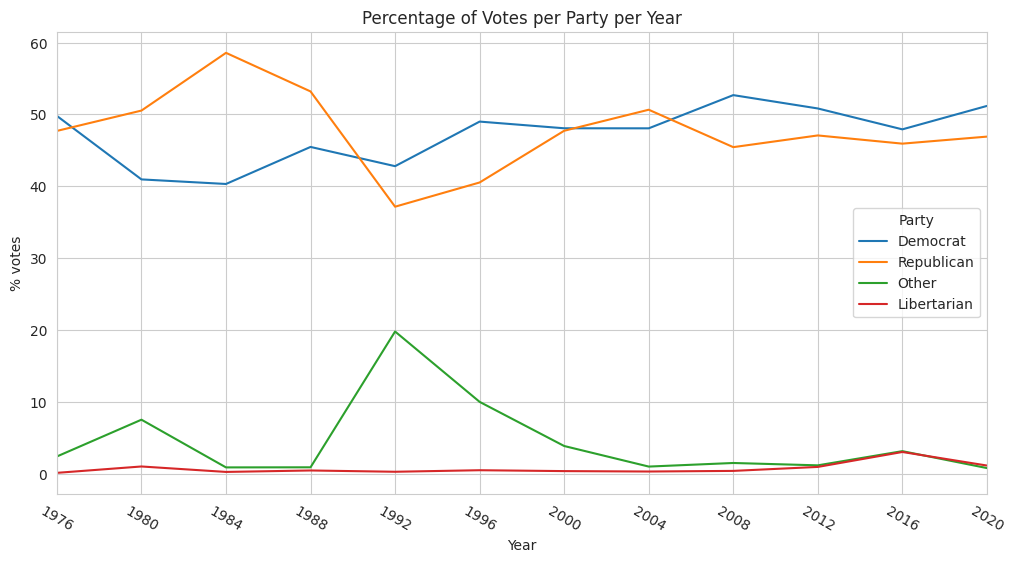

In [14]:
# Create a dictionary of data for each party
data_dict = {
    'Democrat': data_democrat,
    'Republican': data_replublican,
    'Other': data_other,
    'Libertarian': data_libertarian
}

# Call the modified line_plot function
line_plot(data_dict, 'Percentage of Votes per Party per Year')

# Model Selection and Training
# Different approach using electoral college votes

In [29]:
# List of states
states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut',
          'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa',
          'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
          'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
          'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio',
          'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
          'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia',
          'Wisconsin', 'Wyoming']

# Capitalize state names
capitalized_states = [state.upper() for state in states]

# Electoral votes data
electoral_votes = {
    'state': capitalized_states,
    'electoral_votes': [9, 3, 11, 6, 55, 9, 7, 3, 29, 16, 4, 4, 20, 11, 6, 6, 8, 8, 4, 10, 11, 16, 10, 6, 10,
                        3, 5, 6, 4, 14, 5, 29, 15, 3, 18, 7, 7, 20, 4, 9, 3, 11, 38, 6, 3, 13, 12, 5, 10, 3]
}

# Create DataFrame from electoral votes data
electoral_votes_df = pd.DataFrame(electoral_votes)

#print(electoral_votes_df)

# Preprocessing the data to prepare for the machine learning models

In [30]:
# Aggregate votes by party, state, and year
party_votes = modeling_df.groupby(['year', 'state', 'party_detailed'])['candidatevotes'].sum().reset_index()

# Ensure there is only one winner per state per year
party_votes = party_votes.sort_values(by=['year', 'state', 'candidatevotes'], ascending=[True, True, False])
party_votes['rank'] = party_votes.groupby(['year', 'state'])['candidatevotes'].rank(method='first', ascending=False)

# Filter to keep only the top-ranked party for each state and year
winning_party = party_votes[party_votes['rank'] == 1].drop(columns=['rank'])

# Create a DataFrame with the winning party for each state and year
winner_table = winning_party[['year', 'state', 'party_detailed']]
winner_table.rename(columns={'party_detailed': 'winning_party'}, inplace=True)

# Aggregate votes by party, state, and year
party_votes = modeling_df.groupby(['year', 'state', 'party_detailed'])['candidatevotes'].sum().reset_index()

# Ensure there is only one winner per state per year
party_votes = party_votes.sort_values(by=['year', 'state', 'candidatevotes'], ascending=[True, True, False])
party_votes['rank'] = party_votes.groupby(['year', 'state'])['candidatevotes'].rank(method='first', ascending=False)

# Filter to keep only the top-ranked party for each state and year
winning_party = party_votes[party_votes['rank'] == 1].drop(columns=['rank'])

# Create a DataFrame with the winning party for each state and year
winner_table = winning_party[['year', 'state', 'party_detailed']]
winner_table.rename(columns={'party_detailed': 'winning_party'}, inplace=True)

# Calculate previous winning party
winner_table['previous_winning_party'] = winner_table.groupby('state')['winning_party'].shift(1)

# Merge winner table with electoral votes
winner_table = winner_table.merge(electoral_votes_df, on='state', how='left')

# Prepare data for training (1976-2016) and testing (2020)
train_data = winner_table[(winner_table['year'] >= 1976) & (winner_table['year'] <= 2016)]
test_data = winner_table[winner_table['year'] == 2020]

# Prepare the training data
X_train = train_data[['year', 'state', 'previous_winning_party']]
y_train = train_data['winning_party']

# Prepare data for a specific year to predict (e.g., 2020)
X_test = test_data[['year', 'state', 'previous_winning_party']]
y_test = test_data['winning_party']  # Actual labels for comparison

# Encode categorical features
X_train = pd.get_dummies(X_train, columns=['state', 'previous_winning_party'])
X_test = pd.get_dummies(X_test, columns=['state', 'previous_winning_party'])

# Ensure X_train and X_test have the same columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [31]:
# Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga']
}

# MLPClassifier
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['relu'],  # Limited to 'relu' for simplicity
    'solver': ['adam'],  # Limited to 'adam'
    'alpha': [0.0001, 0.001],  # Reduced alpha values
    'learning_rate': ['constant'],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [200, 500]
}

# Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Define RandomizedSearchCV for MLPClassifier
random_search_mlp = RandomizedSearchCV(
    MLPClassifier(random_state=42),
    param_distributions=param_grid_mlp,
    n_iter=5,  # Number of random combinations to sample
    cv=5,
    scoring='accuracy',
    n_jobs=-1,  # Use all available CPU cores
    random_state=42
)

# Define a function to train and evaluate models with cross-validation
def train_and_evaluate_model(clf, X_train, y_train, X_test, y_test, test_data, param_grid=None, search_type='grid'):
    if param_grid:
        if search_type == 'grid':
            search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        elif search_type == 'random':
            search = RandomizedSearchCV(clf, param_distributions=param_grid, cv=5, n_iter=10, scoring='accuracy', n_jobs=-1, random_state=42)
        search.fit(X_train, y_train)
        best_model = search.best_estimator_
    else:
        best_model = clf
        best_model.fit(X_train, y_train)

    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')

    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=test_data['winning_party'].unique())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data['winning_party'].unique())
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.show()

    test_predictions = pd.DataFrame(X_test.copy())
    test_predictions['predicted_winning_party'] = y_pred
    test_predictions['state'] = test_data['state'].values
    test_predictions['electoral_votes'] = test_data['electoral_votes'].values

    electoral_votes_by_party_2020 = test_predictions.groupby('predicted_winning_party')['electoral_votes'].sum()
    overall_winner = electoral_votes_by_party_2020.idxmax()
    print(f'The overall predicted winner for 2020 is: {overall_winner}')

    print("\nElectoral votes won by each party in 2020:")
    for party, votes in electoral_votes_by_party_2020.items():
        print(f"{party}: {votes} electoral votes")

    for party in electoral_votes_by_party_2020.index:
        states_won = test_predictions[test_predictions['predicted_winning_party'] == party]['state'].tolist()
        print(f"\nThe {party} party won {len(states_won)} states. They are: {', '.join(states_won)}")

    # Print classification report
    print(f'Classification Report:')
    print(classification_report(y_test, y_pred))
    print('-' * 60)

# Train and test models, predicting 2020

Random Forest Classifier



Accuracy: 0.82


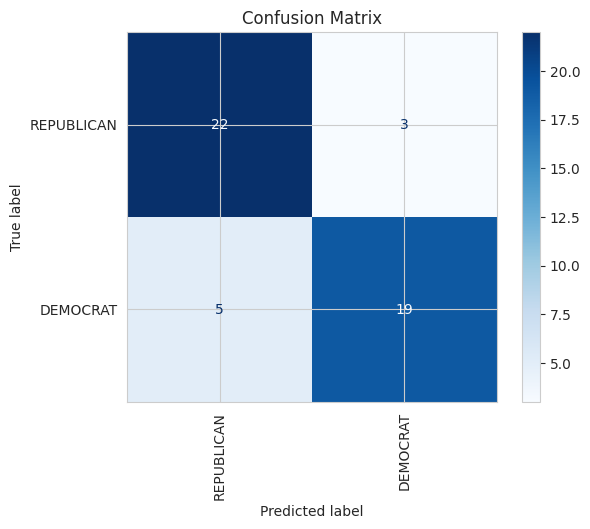

The overall predicted winner for 2020 is: DEMOCRAT

Electoral votes won by each party in 2020:
DEMOCRAT: 273 electoral votes
DEMOCRATIC-FARMER-LABOR: 10 electoral votes
REPUBLICAN: 252 electoral votes

The DEMOCRAT party won 22 states. They are: CALIFORNIA, COLORADO, CONNECTICUT, DELAWARE, FLORIDA, HAWAII, ILLINOIS, IOWA, MAINE, MARYLAND, MASSACHUSETTS, NEVADA, NEW HAMPSHIRE, NEW JERSEY, NEW MEXICO, NEW YORK, OHIO, OREGON, RHODE ISLAND, VERMONT, VIRGINIA, WASHINGTON

The DEMOCRATIC-FARMER-LABOR party won 1 states. They are: MINNESOTA

The REPUBLICAN party won 27 states. They are: ALABAMA, ALASKA, ARIZONA, ARKANSAS, GEORGIA, IDAHO, INDIANA, KANSAS, KENTUCKY, LOUISIANA, MICHIGAN, MISSISSIPPI, MISSOURI, MONTANA, NEBRASKA, NORTH CAROLINA, NORTH DAKOTA, OKLAHOMA, PENNSYLVANIA, SOUTH CAROLINA, SOUTH DAKOTA, TENNESSEE, TEXAS, UTAH, WEST VIRGINIA, WISCONSIN, WYOMING
Classification Report:
                         precision    recall  f1-score   support

               DEMOCRAT       0.86      

In [32]:
# RandomForestClassifier
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
train_and_evaluate_model(clf_rf, X_train, y_train, X_test, y_test, test_data)

Logistic Regression



Accuracy: 0.90


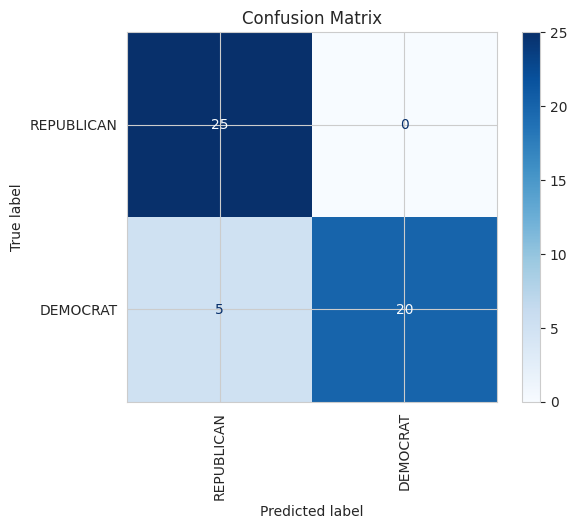

The overall predicted winner for 2020 is: REPUBLICAN

Electoral votes won by each party in 2020:
DEMOCRAT: 230 electoral votes
REPUBLICAN: 305 electoral votes

The DEMOCRAT party won 20 states. They are: CALIFORNIA, COLORADO, CONNECTICUT, DELAWARE, HAWAII, ILLINOIS, MAINE, MARYLAND, MASSACHUSETTS, MINNESOTA, NEVADA, NEW HAMPSHIRE, NEW JERSEY, NEW MEXICO, NEW YORK, OREGON, RHODE ISLAND, VERMONT, VIRGINIA, WASHINGTON

The REPUBLICAN party won 30 states. They are: ALABAMA, ALASKA, ARIZONA, ARKANSAS, FLORIDA, GEORGIA, IDAHO, INDIANA, IOWA, KANSAS, KENTUCKY, LOUISIANA, MICHIGAN, MISSISSIPPI, MISSOURI, MONTANA, NEBRASKA, NORTH CAROLINA, NORTH DAKOTA, OHIO, OKLAHOMA, PENNSYLVANIA, SOUTH CAROLINA, SOUTH DAKOTA, TENNESSEE, TEXAS, UTAH, WEST VIRGINIA, WISCONSIN, WYOMING
Classification Report:
              precision    recall  f1-score   support

    DEMOCRAT       1.00      0.80      0.89        25
  REPUBLICAN       0.83      1.00      0.91        25

    accuracy                           0.9

In [33]:
# LogisticRegression with GridSearchCV (l1, l2 penalties)
clf_lr = LogisticRegression(random_state=42)
train_and_evaluate_model(clf_lr, X_train, y_train, X_test, y_test, test_data, param_grid_lr)

Gradient Boosting Classifier



Accuracy: 0.90


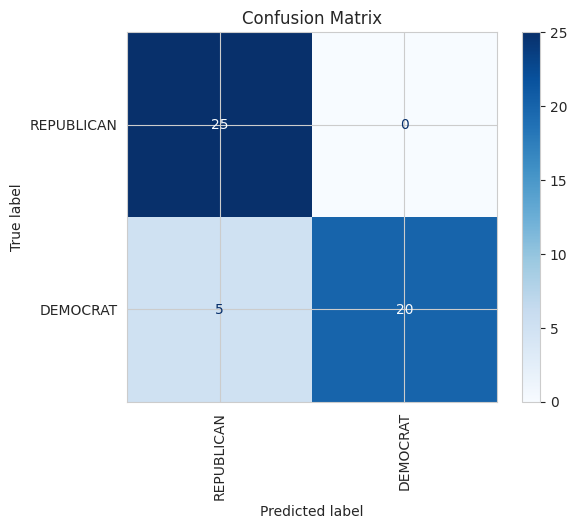

The overall predicted winner for 2020 is: REPUBLICAN

Electoral votes won by each party in 2020:
DEMOCRAT: 230 electoral votes
REPUBLICAN: 305 electoral votes

The DEMOCRAT party won 20 states. They are: CALIFORNIA, COLORADO, CONNECTICUT, DELAWARE, HAWAII, ILLINOIS, MAINE, MARYLAND, MASSACHUSETTS, MINNESOTA, NEVADA, NEW HAMPSHIRE, NEW JERSEY, NEW MEXICO, NEW YORK, OREGON, RHODE ISLAND, VERMONT, VIRGINIA, WASHINGTON

The REPUBLICAN party won 30 states. They are: ALABAMA, ALASKA, ARIZONA, ARKANSAS, FLORIDA, GEORGIA, IDAHO, INDIANA, IOWA, KANSAS, KENTUCKY, LOUISIANA, MICHIGAN, MISSISSIPPI, MISSOURI, MONTANA, NEBRASKA, NORTH CAROLINA, NORTH DAKOTA, OHIO, OKLAHOMA, PENNSYLVANIA, SOUTH CAROLINA, SOUTH DAKOTA, TENNESSEE, TEXAS, UTAH, WEST VIRGINIA, WISCONSIN, WYOMING
Classification Report:
              precision    recall  f1-score   support

    DEMOCRAT       1.00      0.80      0.89        25
  REPUBLICAN       0.83      1.00      0.91        25

    accuracy                           0.9

In [34]:
# GradientBoostingClassifier with GridSearchCV
clf_gb = GradientBoostingClassifier(random_state=42)
train_and_evaluate_model(clf_gb, X_train, y_train, X_test, y_test, test_data, param_grid_gb, search_type='random')

Support Vector Machine


Accuracy: 0.50


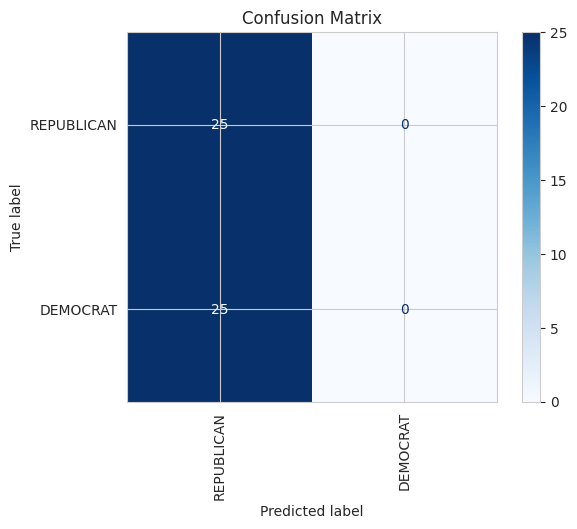

The overall predicted winner for 2020 is: REPUBLICAN

Electoral votes won by each party in 2020:
REPUBLICAN: 535 electoral votes

The REPUBLICAN party won 50 states. They are: ALABAMA, ALASKA, ARIZONA, ARKANSAS, CALIFORNIA, COLORADO, CONNECTICUT, DELAWARE, FLORIDA, GEORGIA, HAWAII, IDAHO, ILLINOIS, INDIANA, IOWA, KANSAS, KENTUCKY, LOUISIANA, MAINE, MARYLAND, MASSACHUSETTS, MICHIGAN, MINNESOTA, MISSISSIPPI, MISSOURI, MONTANA, NEBRASKA, NEVADA, NEW HAMPSHIRE, NEW JERSEY, NEW MEXICO, NEW YORK, NORTH CAROLINA, NORTH DAKOTA, OHIO, OKLAHOMA, OREGON, PENNSYLVANIA, RHODE ISLAND, SOUTH CAROLINA, SOUTH DAKOTA, TENNESSEE, TEXAS, UTAH, VERMONT, VIRGINIA, WASHINGTON, WEST VIRGINIA, WISCONSIN, WYOMING
Classification Report:
              precision    recall  f1-score   support

    DEMOCRAT       0.00      0.00      0.00        25
  REPUBLICAN       0.50      1.00      0.67        25

    accuracy                           0.50        50
   macro avg       0.25      0.50      0.33        50
weighted

In [35]:
# SVM
clf_svm = SVC(random_state=42)
train_and_evaluate_model(clf_svm, X_train, y_train, X_test, y_test, test_data)

Multi-Layer Perceptron Classifier (MLPC)



Accuracy: 0.90


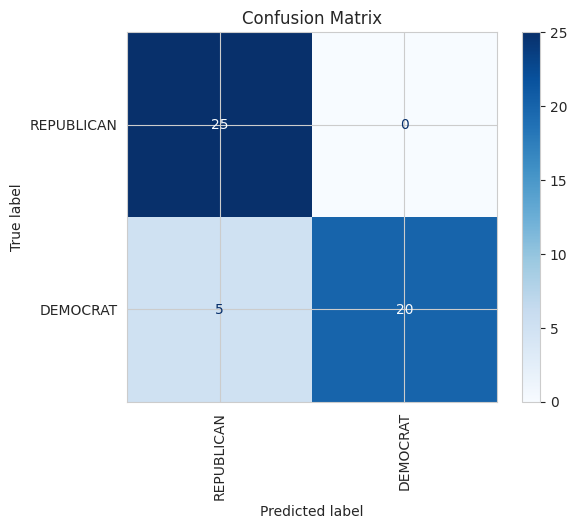

The overall predicted winner for 2020 is: REPUBLICAN

Electoral votes won by each party in 2020:
DEMOCRAT: 230 electoral votes
REPUBLICAN: 305 electoral votes

The DEMOCRAT party won 20 states. They are: CALIFORNIA, COLORADO, CONNECTICUT, DELAWARE, HAWAII, ILLINOIS, MAINE, MARYLAND, MASSACHUSETTS, MINNESOTA, NEVADA, NEW HAMPSHIRE, NEW JERSEY, NEW MEXICO, NEW YORK, OREGON, RHODE ISLAND, VERMONT, VIRGINIA, WASHINGTON

The REPUBLICAN party won 30 states. They are: ALABAMA, ALASKA, ARIZONA, ARKANSAS, FLORIDA, GEORGIA, IDAHO, INDIANA, IOWA, KANSAS, KENTUCKY, LOUISIANA, MICHIGAN, MISSISSIPPI, MISSOURI, MONTANA, NEBRASKA, NORTH CAROLINA, NORTH DAKOTA, OHIO, OKLAHOMA, PENNSYLVANIA, SOUTH CAROLINA, SOUTH DAKOTA, TENNESSEE, TEXAS, UTAH, WEST VIRGINIA, WISCONSIN, WYOMING
Classification Report:
              precision    recall  f1-score   support

    DEMOCRAT       1.00      0.80      0.89        25
  REPUBLICAN       0.83      1.00      0.91        25

    accuracy                           0.9

In [36]:
# MLPClassifier with GridSearchCV
clf_mlp = MLPClassifier(random_state=42)
train_and_evaluate_model(clf_mlp, X_train, y_train, X_test, y_test, test_data, param_grid_mlp)

# Predict 2024 Result

In [39]:
# Split the data
train_data = modeling_df[modeling_df['year'] < 2020]
test_data = modeling_df[modeling_df['year'] == 2020]
predict_data = modeling_df[modeling_df['year'] == 2024]

# Define features and target
features = ['state', 'candidate', 'party_detailed', 'candidatevotes', 'totalvotes']
target = 'party_simplified'

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]
X_predict = predict_data[features]

# Encode categorical features
label_encoders = {}
for feature in ['state', 'candidate', 'party_detailed']:
    le = LabelEncoder()
    # Fit on the combined data to ensure all possible labels are seen
    le.fit(pd.concat([X_train[feature], X_test[feature], X_predict[feature]]).astype(str))
    X_train[feature] = le.transform(X_train[feature].astype(str))
    X_test[feature] = le.transform(X_test[feature].astype(str))
    X_predict[feature] = le.transform(X_predict[feature].astype(str))
    label_encoders[feature] = le

# Encode target variable
target_encoder = LabelEncoder()
y_train = target_encoder.fit_transform(y_train)
y_test = target_encoder.transform(y_test)

# Initialize models
rf_model = RandomForestClassifier()

# Train models
rf_model.fit(X_train, y_train)

# Evaluate models
rf_y_pred_test = rf_model.predict(X_test)

print("Random Forest Test Accuracy:", accuracy_score(y_test, rf_y_pred_test))
print("Random Forest Classification Report:\n", classification_report(y_test, rf_y_pred_test))

# Predict future results
rf_y_pred_future = rf_model.predict(X_predict)

# Decode predictions
rf_predictions = target_encoder.inverse_transform(rf_y_pred_future)

predict_data['rf_predicted_party'] = rf_predictions

print("Random Forest Predictions for 2024:")
print(predict_data[['state', 'candidate', 'rf_predicted_party']])

Random Forest Test Accuracy: 0.9981481481481481
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.98      1.00      0.99        48
           2       1.00      1.00      1.00       392
           3       1.00      1.00      1.00        50

    accuracy                           1.00       540
   macro avg       0.99      1.00      1.00       540
weighted avg       1.00      1.00      1.00       540



ValueError: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required by RandomForestClassifier.

In [ ]:
predict_data